# Case study of uniaxial tensile tests

This is an example of how to use Paramaterial to process a dataset of uniaxial tensile test measurements.
The data should be formatted as a set of csv files containing measurements for each test, and a single excel spreadsheet containing the metadata for the dataset.
There should be a single row in the excel spreadsheet for each csv file.

The analysis takes 4 stages:
- Data preparation
- Data processing
- Model fitting
- Test report generation

In [1]:
import importlib
import os
import shutil

import pandas as pd
from matplotlib import pyplot as plt

import paramaterial as pam

In [2]:
importlib.reload(pam)

<module 'paramaterial' from 'C:\\Users\\DS\\paramaterial\\paramaterial\\__init__.py'>

## Data preparation

### Prepare backup data
Create directories: "data", "info".
First, save all csv files into a directory called "data/00 backup data".
Generate a corresponding info table "info/00 backup info.xlsx" using make_info_table function.
The function writes the table to a spreadsheet and returns it as a dataframe.
Fill in the info and save backup info and data. Copy to raw info and data.

In [3]:
backup_info = pam.preparing.make_info_table('data/00 backup data')
backup_info.head()

,test id,old filename,test type,material,temperature,rate
0,NaN,P_020_F_1_017_198_18.csv,NaN,NaN,NaN,NaN
1,NaN,P_020_F_2_018_202_19.csv,NaN,NaN,NaN,NaN
2,NaN,P_020_F_3_019_208_25.csv,NaN,NaN,NaN,NaN
3,NaN,P_020_G_1_021_197_16.csv,NaN,NaN,NaN,NaN
4,NaN,P_020_G_2_022_195_24.csv,NaN,NaN,NaN,NaN


Add the metadata and apply a naming convention in the "test id" column.

In [4]:
for i, filename in enumerate(os.listdir('data/00 backup data')):
    test_id = f'testID_{i+1:03d}'
    test_type, temperature, material = filename.split('_')[0:3]
    rate = 8.66e-4

    backup_info.loc[backup_info['old filename']==filename, 'test id'] = test_id
    backup_info.loc[backup_info['old filename']==filename, 'test type'] = test_type  # P is plane-strain tension and T is uniaxial tension
    backup_info.loc[backup_info['old filename']==filename, 'material'] = material  # lot or batch of AA6061
    backup_info.loc[backup_info['old filename']==filename, 'temperature'] = temperature  # Celsius
    backup_info.loc[backup_info['old filename']==filename, 'rate'] = rate  # per second

backup_info.to_excel('info/00 backup info.xlsx', index=False)
backup_info.head()

,test id,old filename,test type,material,temperature,rate
0,testID_001,P_020_F_1_017_198_18.csv,P,F,020,0.000866
1,testID_002,P_020_F_2_018_202_19.csv,P,F,020,0.000866
2,testID_003,P_020_F_3_019_208_25.csv,P,F,020,0.000866
3,testID_004,P_020_G_1_021_197_16.csv,P,G,020,0.000866
4,testID_005,P_020_G_2_022_195_24.csv,P,G,020,0.000866


Copy backup data and info into raw data and info, then leave backup alone in all further steps.

In [5]:
old_dir, new_dir = 'data/00 backup data', 'data/01 raw data'
if os.path.isdir(new_dir): # delete new_dir and files if they already exist
    shutil.rmtree(new_dir)
shutil.copytree(old_dir, new_dir)

shutil.copy('info/00 backup info.xlsx', 'info/01 raw info.xlsx')

'info/01 raw info.xlsx'

### Preparing raw data
Rename files according to test id.

In [6]:
pam.preparing.rename_by_test_id('data/01 raw data', 'info/01 raw info.xlsx')

Renamed 154 files in data/01 raw data.


Check that column headers of data files are all the same.

In [7]:
pam.preparing.check_column_headers('data/01 raw data')

Checking column headers...
First file headers:
	['Strain', 'Stress_MPa']
Headers in all files are the same as in the first file.


### Exploratory data analysis

Now that we have prepared the data, we can use the DataSet class to create a plot of all the raw data.

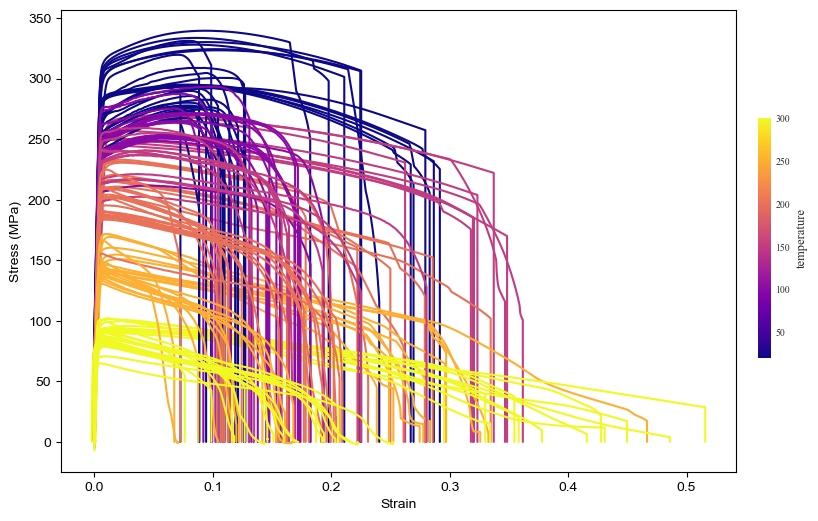

In [8]:
from paramaterial.plug import DataSet

fig, ax = plt.subplots(1, 1, figsize=(9,6))
raw_dataset = DataSet('data/01 raw data', 'info/01 raw info.xlsx')
raw_dataset.plot(ax=ax, colourby='temperature', x='Strain', y='Stress_MPa', xlabel='Strain', ylabel='Stress (MPa)', legend=False)

We can also plot subsets of the dataset with different styles. Here, we style according to test type.

100 54


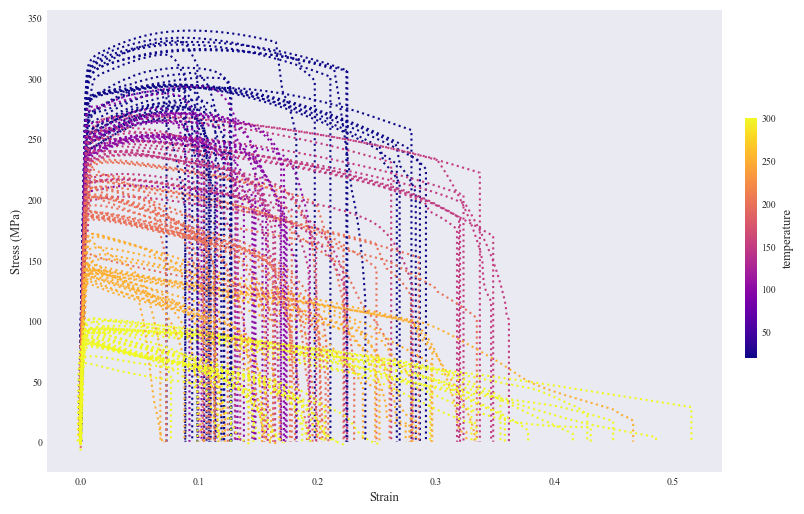

In [11]:
ut_subset = raw_dataset.get_subset({'test type': 'T'})
pst_subset = raw_dataset.get_subset({'test type': 'P'})
print(len(ut_subset), len(pst_subset))
fig, ax = plt.subplots(1, 1, figsize=(9,6))
# ut_subset.plot(ax, colourby='temperature', x='Strain', y='Stress_MPa', xlabel='Strain', ylabel='Stress (MPa)', legend=False, linestyle='-', alpha=0.5)
pst_subset.plot(ax, colourby='temperature', x='Strain', y='Stress_MPa', xlabel='Strain', ylabel='Stress (MPa)', legend=False, linestyle=':')

# todo: work out bug that subset not being plotted but all data is
# todo: make dataset.subplot function